In [139]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image
from PIL import Image
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input

In [140]:
file_path = '/content/drive/MyDrive/dataset2/dataset2/train'
train_dir = '/content/drive/MyDrive/dataset2/dataset2/train'
valid_dir='/content/drive/MyDrive/dataset2/dataset2/valid'
test_dir = '/content/drive/MyDrive/dataset2/dataset2/test'

In [141]:
name_class = os.listdir(file_path)
name_class

['Melanoma Skin Cancer Nevi and Moles',
 'Tinea Ringworm Candidiasis and other Fungal Infections']

In [142]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [143]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,/content/drive/MyDrive/dataset2/dataset2/train...,Melanoma Skin Cancer Nevi and Moles
1,/content/drive/MyDrive/dataset2/dataset2/train...,Melanoma Skin Cancer Nevi and Moles
2,/content/drive/MyDrive/dataset2/dataset2/train...,Melanoma Skin Cancer Nevi and Moles
3,/content/drive/MyDrive/dataset2/dataset2/train...,Tinea Ringworm Candidiasis and other Fungal In...
4,/content/drive/MyDrive/dataset2/dataset2/train...,Melanoma Skin Cancer Nevi and Moles


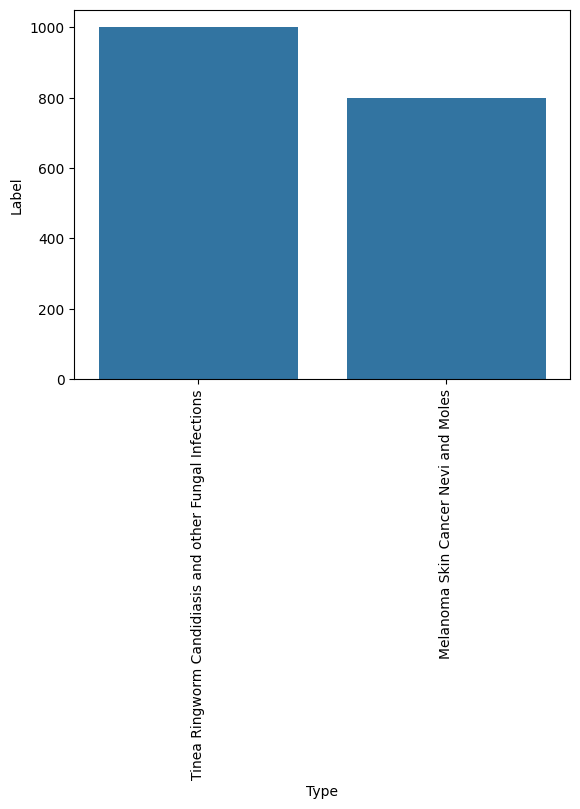

In [144]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [145]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

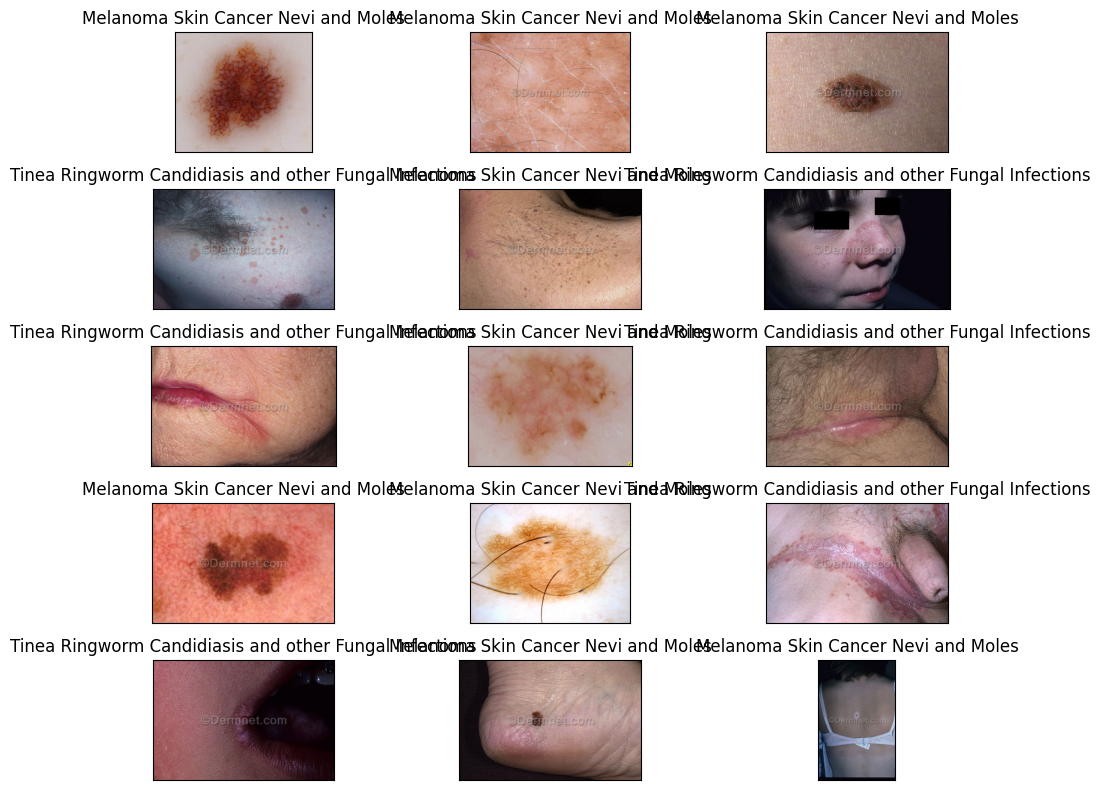

In [146]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [147]:
train_datagen = ImageDataGenerator(zoom_range=0.5,shear_range=0.3, horizontal_flip=True, preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [148]:
train_generator = train_datagen.flow_from_directory(directory= "/content/drive/MyDrive/dataset2/dataset2/train", target_size=(256,256),batch_size=32)
val_generator = val_datagen.flow_from_directory(directory= "/content/drive/MyDrive/dataset2/dataset2/valid", target_size=(256,256),batch_size=32)

Found 1798 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


In [160]:
# Load the ResNet50 model without the top layer (fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [161]:
# Feature extraction: Freeze all layers except the last few for fine-tuning
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [162]:
# Fine-tuning: Allow the last few layers of the ResNet50 model to be trainable
for layer in model.layers[:-10]:
    layer.trainable = True

In [163]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D  # Import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, f1_score
# Add new top layers for our classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [164]:
# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [165]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [166]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [167]:
# Train the model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es= EarlyStopping(monitor='val_accuracy',
                              min_delta=0.01,
                              patience=5,
                               verbose =1,
                  restore_best_weights=True)

mc= ModelCheckpoint(filepath="best_model.h5",
                    monitor='val_accuracy',
                    min_delta = 0.01,
                    patience = 5,
                    verbose =1,
                    mode='max',
                    save_best_only = True)
cb = [es,mc]

In [168]:
history = model.fit(
    train_generator,
    steps_per_epoch=16,
    validation_data=val_generator,
    epochs=20,
    verbose =1,
    callbacks= cb,
    validation_steps=16
)

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 1.5088 - accuracy: 0.7500
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 374s 24s/step - loss: 1.5088 - accuracy: 0.7500 - val_loss: 58.7736 - val_accuracy: 0.5333
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8807
Epoch 2: val_accuracy improved from 0.53333 to 0.74747, saving model to best_model.h5
16/16 [==============================] - 253s 16s/step - loss: 0.3053 - accuracy: 0.8807 - val_loss: 4.7977 - val_accuracy: 0.7475
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 0.2544 - accuracy: 0.8786
Epoch 3: val_accuracy did not improve from 0.74747
16/16 [==============================] - 286s 18s/step - loss: 0.2544 - accuracy: 0.8786 - val_loss: 4.4744 - val_accuracy: 0.7091
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9062
Epoch 4: val_accuracy did not improve from 0.74747
16/16 [==============================] - 265s 17s/step - loss: 0.2224 - accuracy: 0.9062 - val_loss: 1.8920 - val_accuracy: 0.7232
Epoch

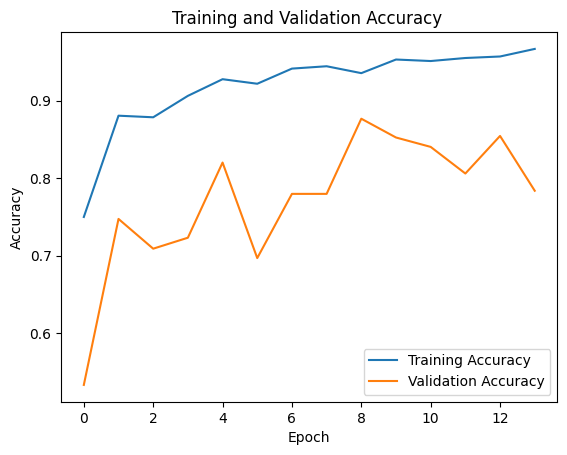

In [169]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

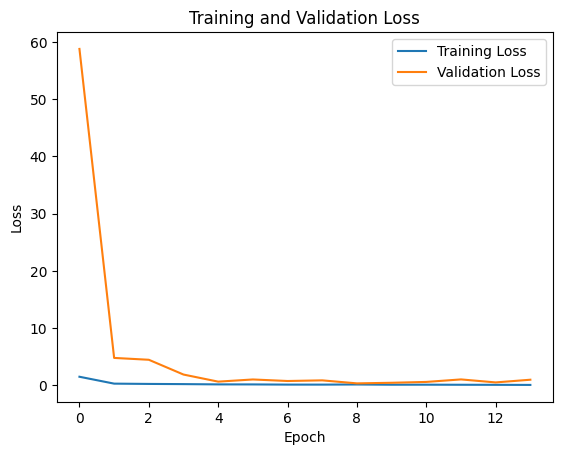

In [170]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [180]:
# Evaluate the model
test_steps = test_generator.samples // batch_size + 1
predictions = model.predict(test_generator, steps=test_steps)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

6/6 [==============================] - 34s 6s/step


In [182]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[  0  46]
 [  0 130]]


In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class names based on your dataset
class_names = ['Melanoma Skin Cancer Nevi and Moles', 'Tinea Ringworm Candidiasis and other Fungal Infections']


In [174]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  0  46]
 [  0 130]]


In [176]:
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nWeighted F1 Score:", f1)


Weighted F1 Score: 0.6275995246583481


In [179]:
from sklearn.metrics import accuracy_score

# Compute testing accuracy
Testing_accuracy = accuracy_score(y_true, y_pred)

# Print Testing accuracy
print(" Testing Accuracy:", Testing_accuracy)


Final Accuracy: 0.7386363636363636


In [184]:
# Assuming you have trained the model using the code snippet provided
# You can access the final training and validation accuracy from the history object

# Get the final training and validation accuracy
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

# Print the final training and validation accuracy
print("Final Training Accuracy:", final_training_accuracy)
print("Final Validation Accuracy:", final_validation_accuracy)


Final Training Accuracy: 0.966796875
Final Validation Accuracy: 0.7838383913040161
